<a href="https://colab.research.google.com/github/baeksumin/k-project/blob/main/data_preprocessing/TimeSeries_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy import interpolate

In [2]:
# 조건에 해당하는 날짜 추출.
def get_point(result):
  x = list(result['x1'])+ list(result['x2'])
  x = list(set(x))
  x.sort()
  return x

# 전체 df에서 해당 날짜만 가져오기
def get_date(date_list):
  check_df =  scode1[scode1.x == date_list[0]]

  for i in date_list :
    df = scode1[scode1.x == i]
    check_df = check_df.append(df,ignore_index = True)

  check_df = check_df.iloc[1:,:]
  return check_df


# 두 점 사이 관계 df 
def two_point (check_df):

  df = check_df[['x']]
  df= df.iloc[:-1]

  df[['x2','y1','y2','t','p','m']] = np.nan
  df.rename(columns ={'x':'x1'}, inplace = True)

  for i in range(len(df)): 
    df.iloc[i,1] = check_df.iloc[i+1,0]
    df.iloc[i,2] = check_df.iloc[i,1]
    df.iloc[i,3] = check_df.iloc[i+1,1]

  for i in range(df.shape[0]):

    t = df.iloc[i,1] - df.iloc[i,0]
    df.iloc[i,4] = t.days

    y1 = df.iloc[i,2]
    y2 = df.iloc[i,3]
    result = (abs(y2 - y1 )) / ((y1+y2)/2 )
    df.iloc[i,5] = result

    m = df.iloc[i,3]- df.iloc[i,2]  
    if (m>0):
      df.iloc[i,6] = 1
    elif (m<0):
      df.iloc[i,6] = -1
    else :
      df.iloc[i,6] = 0

  return df


# 조건 필터링 
def p_t(df):
  t = df['t'] <5
  p = df['p']<0.05

  result = df[~t&~p]
  return result


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_path = '/content/drive/MyDrive/[Shared]K-Project/data/'

# 저장된 개별종목 데이터 가져오기
with open(data_path + 'initial_data1.json',"r") as json_file:
    json_data = json.load(json_file)

#저장된 fullcode 데이터 가져오기
with open(data_path + 'full_code.pkl',"rb") as f: 
    fullcode = pickle.load(f)
    
# 상장폐지 상태 제외시키기
fullcode_filter = fullcode[fullcode['status'] != '상장폐지']

# fullcode열을 list로 변경
fullcode_list = list(fullcode_filter['full_code'])
print(fullcode_list[:10])

['KR7060310000', 'KR7095570008', 'KR7006840003', 'KR7054620000', 'KR7265520007', 'KR7211270004', 'KR7027410000', 'KR7282330000', 'KR7138930003', 'KR7001460005']


In [7]:
global scode1

#5개 시범
for i in range(5): 

  key_list = list(json_data.keys())

  if fullcode_list[i] in key_list:
    df = pd.read_json(json_data[fullcode_list[i]], orient ='index')
    scode = df.transpose()
    print(scode)

    
    #시간 순 재정렬.
    scode = scode.sort_values(by=['TRD_DD'])
    scode.reset_index(drop=True,inplace=True)
    scode['TRD_DD']=pd.to_datetime(scode['TRD_DD']) #datetime변환

    #시가총액 str->float 데이터타입변환
    scode['MKTCAP'] = scode['MKTCAP'].str.replace(',','').astype('float')

    #날짜, 시가총액 열만 추출
    scode1 = scode[['TRD_DD','MKTCAP']]
    #samsung01= samsung01[(samsung01['TRD_DD']>='2017-01-01') & (samsung01['TRD_DD']<='2021-10-20')]
    scode1 = scode1.rename(columns = {'TRD_DD':'x','MKTCAP':'y'})
    scode1.reset_index(drop=True,inplace=True)

    #기울기 변하는 지점 찾아주기
    ischange = list()

    for i in range(1,len(scode1)-2):
      m1 = scode1.iloc[i,1] - scode1.iloc[i-1,1]
      m2 = scode1.iloc[i+1,1] - scode1.iloc[i,1]

      if(m1*m2<=0):
        ischange.append(scode1.iloc[i,0])

    # 전체 df에서 기울기 변하는 지점들만 추출한 후 , (t=5, p=0.05) 에 해당하는 날짜  추출.

    check_df = get_date(ischange) #전체 df에서 기울기 변하는 날짜만 추출하기.
    df = two_point(check_df)
    result = p_t(df)   # (t=5, p=0.05) 에 해당하는 날짜  추출.
    
    # 조건에 해당하는 날짜들끼리 다시 (t=5, p=0.05) 에 해당하는 날짜  추출. 
    red_x = get_point(result)
    red = get_date(red_x)
    df1=two_point(red)
    result2=p_t(df1)

    #점들이 모두 이어지고, 기울기가 계속 변하는 모습 나올때까지 반복 작업.
    while True:
      
      count = 0
      
      red_x1 = get_point(result2) #조건에 만족하는 날짜 추출

      for i in range(result2.shape[0]-1):
        a = result2.iloc[i,1] == result2.iloc[i+1,0]
        b = result2.iloc[i,6]* result2.iloc[i+1,6]== -1

        if(a&b ) :
          count+=1
        
      if (count ==  result2.shape[0]-1 ):
          print(fullcode_list[i]+"조건 성립 완료")
          break
          
      for i in range(result2.shape[0]-1):

        #i번째 기울기 음수일때
        if (result2.iloc[i,6]== -1):  
          #i+1번째 기울기 양수일 때
          if (result2.iloc[i+1,6] == 1): 
            #점이 이어져 있지 않으면
            if (result2.iloc[i,1] != result2.iloc[i+1,0]):
              if(result2.iloc[i,3]> result2.iloc[i+1,2]):
                red_x1.remove(result2.iloc[i,1])
              else :
                red_x1.remove(result2.iloc[i+1,0]) 
                
          #i+1번째 기울기 음수일 때
          elif (result2.iloc [i+1,6]== -1):       
            red_x1.remove(result2.iloc[i,1])


        #i번째 기울기 양수일때
        else :   
          #i+1번째 기울기 양수일 때
          if (result2.iloc[i+1,6] == 1): 
            #점이 이어져 있지 않으면
            if (result2.iloc[i,1] != result2.iloc[i+1,0]):
              red_x1.remove(result2.iloc[i,1])
              red_x1.remove(result2.iloc[i+1,0]) 
            #점이 이어져 있으면
            else :
              red_x1.remove(result2.iloc[i,1])
          #i+1번째 기울기 음수일 때
          else :
            #점이 이어져 있지 않으면
            if (result2.iloc[i,1] != result2.iloc[i+1,0]):
              if (result2.iloc[i,3]>=result2.iloc[i+1,2]):
                red_x1.remove(result2.iloc[i+1,0])
              else:
                red_x1.remove(result2.iloc[i,1])
        
      final = get_date(red_x1)
      df1=two_point(final)
      result2=p_t(df1)
      
    # trend -1~1 사이 값으로 변환.

    final = get_date(red_x1) #최종 기울기 변하는 점 추출.

    for i in range(final.shape[0]-1): #기울기 변하는 곳 1, -1로 값 채워주기
      if(result2.iloc[i,6]== 1):
        final.iloc[i,1] = -1
      else :
        final.iloc[i,1] = 1

    # 마지막 끝 점 (-1,1)해당하는 값으로 채워주기
    n = final.shape[0]-2
    if(final.iloc[n,1]== -1):
      final.iloc[final.shape[0]-1,1] = 1
    else:
      final.iloc[final.shape[0]-1,1] = -1

    # -1~ 1 사이 점 채워주기.
    scode_trend = scode1[['x']]
    scode_trend['TREND'] = np.nan

    for i in range(len(final)):
      scode_trend.loc[scode_trend['x']== final.iloc[i,0],'TREND'] = final.iloc[i,1]

    scode_trend =  scode_trend.set_index('x')
    scode_trend = scode_trend[final.iloc[0,0]:final.iloc[len(final)-1,0]].interpolate(method = "time")

    # 마지막으로 원래 데이터에 TREND 열 만들어주어서 합치기.
    scode_trend.reset_index(inplace=True)
    scode_trend = scode_trend.rename(columns = {'x':'TRD_DD'})
    scode = pd.merge(scode, scode_trend, on='TRD_DD', how='left')
    print(scode)
    print("\n-----------------------------------------------------------------------------------------\n")

          TRD_DD  ISU_CD  ISU_NM TDD_CLSPRC  ...   PBR DPS DVD_YLD ACC_TRDVOL
0     2021/11/09  060310      3S      4,020  ...  5.08   0    0.00       None
1     2021/11/08  060310      3S      4,005  ...  5.06   0    0.00       None
2     2021/11/05  060310      3S      3,985  ...  5.03   0    0.00    295,209
3     2021/11/04  060310      3S      4,115  ...  5.20   0    0.00    131,216
4     2021/11/03  060310      3S      4,180  ...  5.28   0    0.00    204,441
...          ...     ...     ...        ...  ...   ...  ..     ...        ...
4829  2002/04/29  060310  삼에스코리아      6,780  ...     -   -       -    139,388
4830  2002/04/26  060310  삼에스코리아      7,700  ...     -   -       -    176,111
4831  2002/04/25  060310  삼에스코리아      8,750  ...     -   -       -    768,702
4832  2002/04/24  060310  삼에스코리아      8,510  ...     -   -       -    140,723
4833  2002/04/23  060310  삼에스코리아      7,600  ...     -   -       -    109,024

[4834 rows x 15 columns]
KR7035250000조건 성립 완료
         TRD_DD  

In [8]:
scode #마지막 5번째 종목 확인.

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,EPS,PER,BPS,PBR,DPS,DVD_YLD,ACC_TRDVOL,TREND
0,2017-04-07,265520,AP시스템,"41,700","32,100","41,700","32,100",5.704157e+11,-,-,-,-,-,-,"146,984",NaN
1,2017-04-10,265520,AP시스템,"49,900","49,150","52,000","48,100",6.825837e+11,-,-,-,-,-,-,"3,588,963",NaN
2,2017-04-11,265520,AP시스템,"48,950","48,500","49,550","47,000",6.695887e+11,-,-,-,-,-,-,"1,322,228",NaN
3,2017-04-12,265520,AP시스템,"48,600","49,700","50,600","48,300",6.648010e+11,-,-,-,-,-,-,"755,343",-1.000000
4,2017-04-13,265520,AP시스템,"50,300","49,000","50,300","48,300",6.880554e+11,-,-,-,-,-,-,"522,477",-0.959184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,2021-11-03,265520,AP시스템,"24,050","24,200","24,250","23,900",3.675182e+11,"1,736",13.85,"9,041",2.66,120,0.50,"71,772",NaN
1122,2021-11-04,265520,AP시스템,"23,850","24,200","24,450","23,800",3.644619e+11,"1,736",13.74,"9,041",2.64,120,0.50,"80,638",NaN
1123,2021-11-05,265520,AP시스템,"23,550","23,900","23,950","23,400",3.598775e+11,"1,736",13.57,"9,041",2.60,120,0.51,"116,195",NaN
1124,2021-11-08,265520,AP시스템,"23,400","23,300","23,550","22,850",3.575853e+11,"1,736",13.48,"9,041",2.59,120,0.51,None,NaN


In [9]:
scode[~scode.TREND.isnull()] #trend로 변환된 부분 확인.

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,EPS,PER,BPS,PBR,DPS,DVD_YLD,ACC_TRDVOL,TREND
3,2017-04-12,265520,AP시스템,"48,600","49,700","50,600","48,300",6.648010e+11,-,-,-,-,-,-,"755,343",-1.000000
4,2017-04-13,265520,AP시스템,"50,300","49,000","50,300","48,300",6.880554e+11,-,-,-,-,-,-,"522,477",-0.959184
5,2017-04-14,265520,AP시스템,"51,900","51,200","54,400","50,700",7.099418e+11,-,-,-,-,-,-,"1,355,358",-0.918367
6,2017-04-17,265520,AP시스템,"53,900","52,400","54,000","51,200",7.372999e+11,-,-,-,-,-,-,"553,956",-0.795918
7,2017-04-18,265520,AP시스템,"53,900","54,600","55,200","53,600",7.372999e+11,-,-,-,-,-,-,"465,270",-0.755102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,2021-10-08,265520,AP시스템,"23,500","24,050","24,100","23,350",3.402853e+11,"1,736",13.54,"9,041",2.60,120,0.51,"101,800",-0.555556
1105,2021-10-12,265520,AP시스템,"23,000","23,500","23,500","22,850",3.514727e+11,"1,736",13.25,"9,041",2.54,120,0.52,"90,819",0.333333
1106,2021-10-13,265520,AP시스템,"23,300","23,250","23,450","23,050",3.560571e+11,"1,736",13.42,"9,041",2.58,120,0.52,"79,180",0.555556
1107,2021-10-14,265520,AP시스템,"23,750","23,400","23,900","23,350",3.629337e+11,"1,736",13.68,"9,041",2.63,120,0.51,"76,135",0.777778


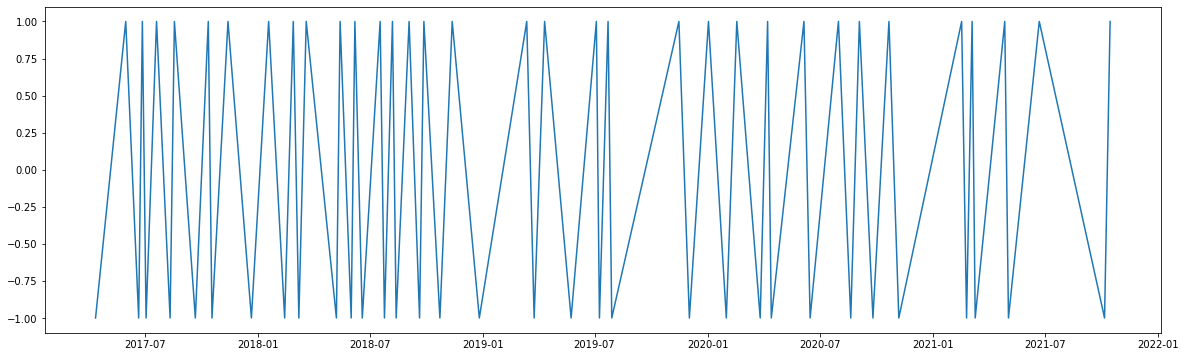

In [11]:
#마지막 5번째 그림으로 확인
plt.figure(figsize=(20,6))
plt.plot(scode.TRD_DD,scode.TREND)

<br><br><br><hr>
<h1><b>삼성전자</b> </h1>

In [12]:
# 삼성전자(KR7005930003) 데이터 가져오기
df = pd.read_json(json_data['KR7005930003'], orient ='index') 
samsung = df.transpose()
samsung

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,EPS,PER,BPS,PBR,DPS,DVD_YLD,ACC_TRDVOL
0,2021/11/09,005930,삼성전자,"70,500","70,300","71,000","70,100","420,869,669,775,000","3,841",18.35,"39,406",1.79,"2,994",4.25,None
1,2021/11/08,005930,삼성전자,"70,600","70,400","70,600","69,800","421,466,648,030,000","3,841",18.38,"39,406",1.79,"2,994",4.24,None
2,2021/11/05,005930,삼성전자,"70,200","71,600","71,600","70,200","419,078,735,010,000","3,841",18.28,"39,406",1.78,"2,994",4.26,"12,667,743"
3,2021/11/04,005930,삼성전자,"70,600","71,200","71,600","70,500","421,466,648,030,000","3,841",18.38,"39,406",1.79,"2,994",4.24,"11,818,987"
4,2021/11/03,005930,삼성전자,"70,400","71,700","71,700","70,100","420,272,691,520,000","3,841",18.33,"39,406",1.79,"2,994",4.25,"12,770,428"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6713,1995/05/08,005930,삼성전자,"121,000","122,000","122,000","120,500","6,578,606,045,000",-,-,-,-,-,-,"91,810"
6714,1995/05/06,005930,삼성전자,"122,000","122,000","123,500","122,000","6,632,974,690,000",-,-,-,-,-,-,"47,440"
6715,1995/05/04,005930,삼성전자,"122,500","124,000","124,500","122,000","6,660,159,012,500",-,-,-,-,-,-,"175,590"
6716,1995/05/03,005930,삼성전자,"123,500","119,500","126,500","119,500","6,714,527,657,500",-,-,-,-,-,-,"382,980"


In [13]:
#시간 순 재정렬.
samsung = samsung.sort_values(by=['TRD_DD'])
samsung.reset_index(drop=True,inplace=True)
samsung['TRD_DD']=pd.to_datetime(samsung['TRD_DD']) #datetime변환

#시가총액 str->float 데이터타입변환
samsung['MKTCAP'] = samsung['MKTCAP'].str.replace(',','').astype('float')

#날짜, 시가총액 열만 추출
samsung01 = samsung[['TRD_DD','MKTCAP']]
#samsung01= samsung01[(samsung01['TRD_DD']>='2017-01-01') & (samsung01['TRD_DD']<='2021-10-20')]
samsung01 = samsung01.rename(columns = {'TRD_DD':'x','MKTCAP':'y'})
samsung01.reset_index(drop=True,inplace=True)
samsung01

,x,y
0,1995-05-02,6.497053e+12
1,1995-05-03,6.714528e+12
2,1995-05-04,6.660159e+12
3,1995-05-06,6.632975e+12
4,1995-05-08,6.578606e+12
...,...,...
6713,2021-11-03,4.202727e+14
6714,2021-11-04,4.214666e+14
6715,2021-11-05,4.190787e+14
6716,2021-11-08,4.214666e+14


In [14]:
# 조건에 해당하는 날짜 추출.
def get_point(result):
  x = list(result['x1'])+ list(result['x2'])
  x = list(set(x))
  x.sort()
  return x

# 전체 df에서 해당 날짜만 가져오기
def get_date(date_list):
  check_df =  samsung01[samsung01.x == date_list[0]]

  for i in date_list :
    df = samsung01[samsung01.x == i]
    check_df = check_df.append(df,ignore_index = True)

  check_df = check_df.iloc[1:,:]
  return check_df


# 두 점 사이 관계 df 
def two_point (check_df):

  df = check_df[['x']]
  df= df.iloc[:-1]

  df[['x2','y1','y2','t','p','m']] = np.nan
  df.rename(columns ={'x':'x1'}, inplace = True)

  for i in range(len(df)): 
    df.iloc[i,1] = check_df.iloc[i+1,0]
    df.iloc[i,2] = check_df.iloc[i,1]
    df.iloc[i,3] = check_df.iloc[i+1,1]

  for i in range(df.shape[0]):

    t = df.iloc[i,1] - df.iloc[i,0]
    df.iloc[i,4] = t.days

    y1 = df.iloc[i,2]
    y2 = df.iloc[i,3]
    result = (abs(y2 - y1 )) / ((y1+y2)/2 )
    df.iloc[i,5] = result

    m = df.iloc[i,3]- df.iloc[i,2]  
    if (m>0):
      df.iloc[i,6] = 1
    elif (m<0):
      df.iloc[i,6] = -1
    else :
      df.iloc[i,6] = 0

  return df


# 조건 필터링 
def p_t(df):
  t = df['t'] <5
  p = df['p']<0.05

  result = df[~t&~p]
  return result


In [15]:
#기울기 변하는 지점 찾아주기

ischange = list()

for i in range(1,len(samsung01)-2):
  m1 = samsung01.iloc[i,1] - samsung01.iloc[i-1,1]
  m2 = samsung01.iloc[i+1,1] - samsung01.iloc[i,1]

  if(m1*m2<=0):
    ischange.append(samsung01.iloc[i,0])

# 전체 df에서 기울기 변하는 지점들만 추출한 후 , (t=5, p=0.05) 에 해당하는 날짜  추출.

check_df = get_date(ischange) #전체 df에서 기울기 변하는 날짜만 추출하기.
df = two_point(check_df)
result = p_t(df)   # (t=5, p=0.05) 에 해당하는 날짜  추출.
result

,x1,x2,y1,y2,t,p,m
1,1995-05-03,1995-05-11 00:00:00,6.714528e+12,6.170841e+12,8.0,0.084388,-1.0
31,1995-07-05,1995-07-12 00:00:00,6.469869e+12,7.910638e+12,7.0,0.200378,1.0
100,1995-12-02,1995-12-09 00:00:00,7.747532e+12,8.862089e+12,7.0,0.134206,1.0
101,1995-12-09,1995-12-18 00:00:00,8.862089e+12,7.176661e+12,9.0,0.210169,-1.0
105,1995-12-23,1996-01-03 00:00:00,7.421320e+12,9.619442e+12,11.0,0.257984,1.0
...,...,...,...,...,...,...,...
3338,2020-12-29,2021-01-05 00:00:00,4.674340e+14,5.008648e+14,7.0,0.069051,1.0
3340,2021-01-06,2021-01-11 00:00:00,4.907161e+14,5.432502e+14,5.0,0.101617,1.0
3371,2021-03-31,2021-04-06 00:00:00,4.859403e+14,5.134013e+14,6.0,0.054958,1.0
3415,2021-07-30,2021-08-04 00:00:00,4.686279e+14,4.948950e+14,5.0,0.054523,1.0


In [16]:
# 조건에 해당하는 날짜들끼리 다시 (t=5, p=0.05) 에 해당하는 날짜  추출. 
red_x = get_point(result)
red = get_date(red_x)
df1=two_point(red)
result2=p_t(df1)
result2

,x1,x2,y1,y2,t,p,m
1,1995-05-03,1995-05-11 00:00:00,6.714528e+12,6.170841e+12,8.0,0.084388,-1.0
3,1995-07-05,1995-07-12 00:00:00,6.469869e+12,7.910638e+12,7.0,0.200378,1.0
5,1995-12-02,1995-12-09 00:00:00,7.747532e+12,8.862089e+12,7.0,0.134206,1.0
6,1995-12-09,1995-12-18 00:00:00,8.862089e+12,7.176661e+12,9.0,0.210169,-1.0
8,1995-12-23,1996-01-03 00:00:00,7.421320e+12,9.619442e+12,11.0,0.257984,1.0
...,...,...,...,...,...,...,...
730,2021-01-11,2021-03-31 00:00:00,5.432502e+14,4.859403e+14,79.0,0.111369,-1.0
731,2021-03-31,2021-04-06 00:00:00,4.859403e+14,5.134013e+14,6.0,0.054958,1.0
732,2021-04-06,2021-07-30 00:00:00,5.134013e+14,4.686279e+14,115.0,0.091185,-1.0
733,2021-07-30,2021-08-04 00:00:00,4.686279e+14,4.948950e+14,5.0,0.054523,1.0


In [17]:
#점들이 모두 이어지고, 기울기가 계속 변하는 모습 나올때까지 반복 작업.

while True:
  
  count = 0
  
  red_x1 = get_point(result2) #조건에 만족하는 날짜 추출

  for i in range(result2.shape[0]-1):
    a = result2.iloc[i,1] == result2.iloc[i+1,0]
    b = result2.iloc[i,6]* result2.iloc[i+1,6]== -1

    if(a&b ) :
      count+=1
    
  if (count ==  result2.shape[0]-1 ):
      print("조건 성립 완료")
      break
      
  for i in range(result2.shape[0]-1):

    #i번째 기울기 음수일때
    if (result2.iloc[i,6]== -1):  
      #i+1번째 기울기 양수일 때
      if (result2.iloc[i+1,6] == 1): 
        #점이 이어져 있지 않으면
        if (result2.iloc[i,1] != result2.iloc[i+1,0]):
          if(result2.iloc[i,3]> result2.iloc[i+2,2]):
            red_x1.remove(result2.iloc[i,1])
          else :
            red_x1.remove(result2.iloc[i+1,0]) 
            
      #i+1번째 기울기 음수일 때
      elif (result2.iloc [i+1,6]== -1):       
        red_x1.remove(result2.iloc[i,1])


    #i번째 기울기 양수일때
    else :   
      #i+1번째 기울기 양수일 때
      if (result2.iloc[i+1,6] == 1): 
        #점이 이어져 있지 않으면
        if (result2.iloc[i,1] != result2.iloc[i+1,0]):
          red_x1.remove(result2.iloc[i,1])
          red_x1.remove(result2.iloc[i+1,0]) 
        #점이 이어져 있으면
        else :
          red_x1.remove(result2.iloc[i,1])
      #i+1번째 기울기 음수일 때
      else :
        #점이 이어져 있지 않으면
        if (result2.iloc[i,1] != result2.iloc[i+1,0]):
          if (result2.iloc[i,3]>=result2.iloc[i+1,2]):
            red_x1.remove(result2.iloc[i+1,0])
          else:
            red_x1.remove(result2.iloc[i,1])
     
  final = get_date(red_x1)
  df1=two_point(final)
  result2=p_t(df1)
  result2


조건 성립 완료


In [18]:
result2

,x1,x2,y1,y2,t,p,m
1,1995-05-03,1995-05-11 00:00:00,6.714528e+12,6.170841e+12,8.0,0.084388,-1.0
2,1995-05-11,1995-12-09 00:00:00,6.170841e+12,8.862089e+12,212.0,0.358047,1.0
3,1995-12-09,1995-12-18 00:00:00,8.862089e+12,7.176661e+12,9.0,0.210169,-1.0
4,1995-12-18,1996-01-03 00:00:00,7.176661e+12,9.619442e+12,16.0,0.290875,1.0
5,1996-01-03,1996-03-14 00:00:00,9.619442e+12,5.690374e+12,71.0,0.513274,-1.0
...,...,...,...,...,...,...,...
291,2021-01-11,2021-03-31 00:00:00,5.432502e+14,4.859403e+14,79.0,0.111369,-1.0
292,2021-03-31,2021-04-06 00:00:00,4.859403e+14,5.134013e+14,6.0,0.054958,1.0
293,2021-04-06,2021-07-30 00:00:00,5.134013e+14,4.686279e+14,115.0,0.091185,-1.0
294,2021-07-30,2021-08-04 00:00:00,4.686279e+14,4.948950e+14,5.0,0.054523,1.0


In [19]:
# trend -1~1 사이 값으로 변환.

final = get_date(red_x1) #최종 기울기 변하는 점 추출.

for i in range(final.shape[0]-1): #기울기 변하는 곳 1, -1로 값 채워주기
  if(result2.iloc[i,6]== 1):
    final.iloc[i,1] = -1
  else :
    final.iloc[i,1] = 1

# 마지막 끝 점 (-1,1)해당하는 값으로 채워주기
n = final.shape[0]-2
if(final.iloc[n,1]== -1):
  final.iloc[final.shape[0]-1,1] = 1
else:
  final.iloc[final.shape[0]-1,1] = -1

# -1~ 1 사이 점 채워주기.
samsung_trend = samsung01[['x']]
samsung_trend['TREND'] = np.nan

for i in range(len(final)):
  samsung_trend.loc[samsung_trend['x']== final.iloc[i,0],'TREND'] = final.iloc[i,1]

samsung_trend =  samsung_trend.set_index('x')
samsung_trend = samsung_trend[final.iloc[0,0]:final.iloc[len(final)-1,0]].interpolate(method = "time")

# 마지막으로 원래 데이터에 TREND 열 만들어주어서 합치기.
samsung_trend.reset_index(inplace=True)
samsung_trend = samsung_trend.rename(columns = {'x':'TRD_DD'})
samsung = pd.merge(samsung, samsung_trend, on='TRD_DD', how='left')
samsung

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,EPS,PER,BPS,PBR,DPS,DVD_YLD,ACC_TRDVOL,TREND
0,1995-05-02,005930,삼성전자,"119,500","121,000","121,000","118,500",6.497053e+12,-,-,-,-,-,-,"139,560",NaN
1,1995-05-03,005930,삼성전자,"123,500","119,500","126,500","119,500",6.714528e+12,-,-,-,-,-,-,"382,980",1.00
2,1995-05-04,005930,삼성전자,"122,500","124,000","124,500","122,000",6.660159e+12,-,-,-,-,-,-,"175,590",0.75
3,1995-05-06,005930,삼성전자,"122,000","122,000","123,500","122,000",6.632975e+12,-,-,-,-,-,-,"47,440",0.25
4,1995-05-08,005930,삼성전자,"121,000","122,000","122,000","120,500",6.578606e+12,-,-,-,-,-,-,"91,810",-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6713,2021-11-03,005930,삼성전자,"70,400","71,700","71,700","70,100",4.202727e+14,"3,841",18.33,"39,406",1.79,"2,994",4.25,"12,770,428",NaN
6714,2021-11-04,005930,삼성전자,"70,600","71,200","71,600","70,500",4.214666e+14,"3,841",18.38,"39,406",1.79,"2,994",4.24,"11,818,987",NaN
6715,2021-11-05,005930,삼성전자,"70,200","71,600","71,600","70,200",4.190787e+14,"3,841",18.28,"39,406",1.78,"2,994",4.26,"12,667,743",NaN
6716,2021-11-08,005930,삼성전자,"70,600","70,400","70,600","69,800",4.214666e+14,"3,841",18.38,"39,406",1.79,"2,994",4.24,None,NaN
